In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from tqdm import tqdm

In [2]:
# if torch.backends.mps.is_available():
#     torch.set_default_device("mps")

In [3]:
# 1. Generate a synthetic dataset
def create_sin_wave_data(seq_length, num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        start = np.random.rand() * 2 * np.pi
        x = np.linspace(start, start + 10, seq_length + 1)
        data = np.sin(x)
        X.append(data[:-1])
        y.append(data[-1])
    return np.array(X), np.array(y)

In [4]:
num_samples = 1000
seq_length = 50

X, y = create_sin_wave_data(seq_length, num_samples)
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

In [5]:
X.shape, X.device, y.shape, y.device

(torch.Size([1000, 50, 1]),
 device(type='cpu'),
 torch.Size([1000, 1]),
 device(type='cpu'))

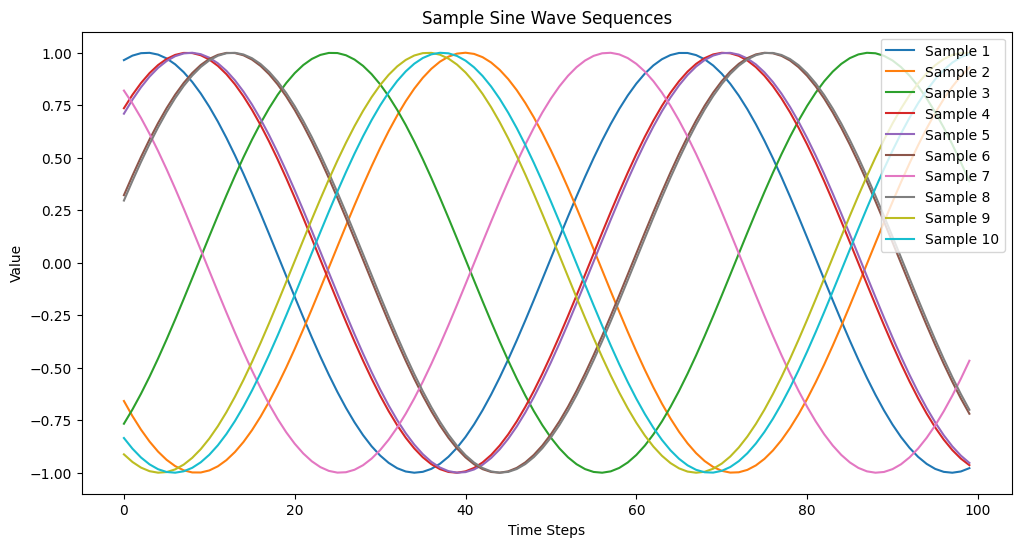

In [6]:
# 1-1. Visualize the data
num_samples = 10
seq_length = 100
X_vis, _ = create_sin_wave_data(seq_length, num_samples)

# Plot sample data
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.plot(X_vis[i], label=f"Sample {i+1}")
plt.title("Sample Sine Wave Sequences")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend(loc="upper right")
plt.show()

In [14]:
# 2. Define the LSTM network
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# 3. Define model, loss, and optimizer
model = LSTMNetwork()
# model.to('mps')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
summary(
    model,
    input_size=(10, 50, 1),
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMNetwork                              [10, 50, 1]               [10, 1]                   --
├─LSTM: 1-1                              [10, 50, 1]               [10, 50, 64]              17,152
├─Linear: 1-2                            [10, 64]                  [10, 1]                   65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.07
Estimated Total Size (MB): 0.33

In [17]:
loss_line = []

100%|██████████| 400/400 [00:45<00:00,  8.73it/s, Loss: 1.1999544540231e-06]   


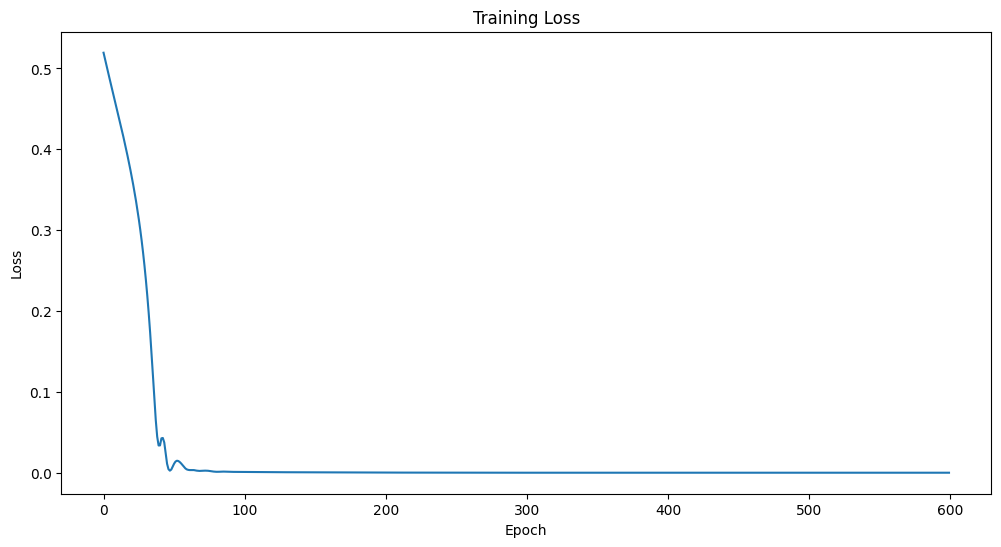

In [20]:
# 4. Train the LSTM network
num_epochs = 400
for epoch in (pbar := tqdm(range(num_epochs))):
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs, y)
    pbar.set_postfix_str(f"Loss: {loss.item()}")
    loss_line.append(loss.item())
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 6))
plt.plot(loss_line)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

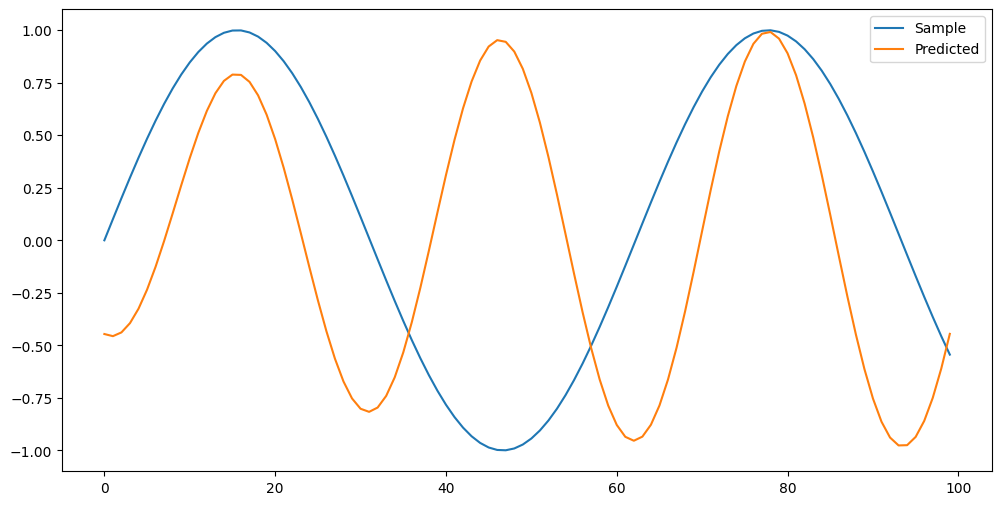

In [22]:
# 5. Make predictions
model.eval()
with torch.no_grad():
    test_seq = np.sin(np.linspace(0, 10, seq_length)).reshape(1, -1, 1)
    test_seq_T = torch.FloatTensor(test_seq)

    # Plot the results
    predicted_values = []
    for i in range(100):
        predicted_value = model(test_seq_T)
        predicted_values.append(predicted_value.item())
        test_seq_T = torch.cat((test_seq_T[:, 1:, :], predicted_value.view(1, 1, 1)), dim=1)

    plt.figure(figsize=(12, 6))
    plt.plot(test_seq.reshape(-1), label="Sample")
    plt.plot(predicted_values, label="Predicted")
    plt.legend()
    plt.show()